# <center>CO2 LSTM Forecasting</center>

> Authors:
> - D11202805 - Ian Joseph Chandra
> - M11002818 - Wilfrid Azariah

## Step 1: Import Libraries

In [1730]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from datetime import timedelta

# # Load data
df = pd.read_csv('./data/emissions.csv')

df

,year,state-name,sector-name,fuel-name,value
0,1970,Alabama,Industrial carbon dioxide emissions,Coal,26.721507
1,1970,Alabama,Industrial carbon dioxide emissions,Petroleum,3.577779
2,1970,Alabama,Industrial carbon dioxide emissions,Natural Gas,8.944097
3,1970,Alabama,Industrial carbon dioxide emissions,All Fuels,39.243383
4,1970,Alabama,Total carbon dioxide emissions from all sectors,All Fuels,102.646851
...,...,...,...,...,...
59896,2021,Wyoming,Commercial carbon dioxide emissions,Coal,0.012374
59897,2021,Wyoming,Residential carbon dioxide emissions,All Fuels,0.937989
59898,2021,Wyoming,Residential carbon dioxide emissions,Natural Gas,0.717777
59899,2021,Wyoming,Residential carbon dioxide emissions,Petroleum,0.220212


# Step 2: Data Preprocessing

### 2.1 Data Cleaning

In [1731]:
# Remove "-name" from column names
df.columns = df.columns.str.replace('-name', '')

# Rename value column to "emission"
df = df.rename(columns={'value': 'emission'})

# Remove "carbon dioxide emissions" from 'sector' column
df['sector'] = df['sector'].str.replace(' carbon dioxide emissions', '')

# Remove rows where 'fuel' column contains "All Fuels"
df = df[~df['fuel'].str.contains('All Fuels')]

# Remove rows where 'sector' column contains "Total"
df = df[~df['sector'].str.contains('Total')]

df

,year,state,sector,fuel,emission
0,1970,Alabama,Industrial,Coal,26.721507
1,1970,Alabama,Industrial,Petroleum,3.577779
2,1970,Alabama,Industrial,Natural Gas,8.944097
8,1970,Alabama,Residential,Coal,0.163635
9,1970,Alabama,Residential,Petroleum,1.123947
...,...,...,...,...,...
59894,2021,Wyoming,Commercial,Natural Gas,0.686983
59895,2021,Wyoming,Commercial,Petroleum,0.216315
59896,2021,Wyoming,Commercial,Coal,0.012374
59898,2021,Wyoming,Residential,Natural Gas,0.717777


### 2.2 Data Classification

In [1732]:
# Exclude 'state' column & group by 'year', 'sector', 'fuel'
df = df.drop('state', axis=1)
state_excluded = df.groupby(['year', 'sector', 'fuel'], as_index=False)['emission'].sum()
state_excluded

,year,sector,fuel,emission
0,1970,Commercial,Coal,31.306261
1,1970,Commercial,Natural Gas,260.289232
2,1970,Commercial,Petroleum,233.356940
3,1970,Electric Power,Coal,1374.959395
4,1970,Electric Power,Natural Gas,429.208459
...,...,...,...,...
717,2021,Industrial,Petroleum,698.180684
718,2021,Residential,Natural Gas,520.017628
719,2021,Residential,Petroleum,132.467958
720,2021,Transportation,Natural Gas,129.829709


In [1733]:
# Group by fuel
fuel_group = state_excluded.groupby(['year', 'fuel'], as_index=False)['emission'].sum()

# Create a dictionary where each key is a type of fuel and each value is a DataFrame containing the data for that type of fuel
fuels = {fuel: fuel_group[fuel_group['fuel'] == fuel] for fuel in fuel_group['fuel'].unique()}

# Drop the 'fuel' column from each DataFrame in the dictionary
for fuel in fuels:
    fuels[fuel] = fuels[fuel].drop(columns='fuel')
    
fuels['names'] = fuel_group['fuel'].unique()

fuels

{'Coal':      year     emission
 0    1970  2311.126560
 3    1971  2187.743724
 6    1972  2283.000112
 9    1973  2443.490583
 12   1974  2386.105741
 15   1975  2388.027333
 18   1976  2563.195745
 21   1977  2627.566307
 24   1978  2602.873837
 27   1979  2843.300211
 30   1980  2924.836740
 33   1981  3016.997098
 36   1982  2894.453933
 39   1983  3009.112576
 42   1984  3225.430596
 45   1985  3326.168963
 48   1986  3272.427202
 51   1987  3406.837920
 54   1988  3584.902972
 57   1989  3617.355257
 60   1990  3638.854087
 63   1991  3610.042113
 66   1992  3635.494141
 69   1993  3758.272863
 72   1994  3770.835057
 75   1995  3813.294965
 78   1996  3984.510120
 81   1997  4067.450536
 84   1998  4098.322338
 87   1999  4102.382660
 90   2000  4293.881862
 93   2001  4167.281271
 96   2002  4172.197235
 99   2003  4257.868684
 102  2004  4285.010742
 105  2005  4350.835494
 108  2006  4278.512602
 111  2007  4336.251597
 114  2008  4268.147608
 117  2009  3756.028591
 120  20

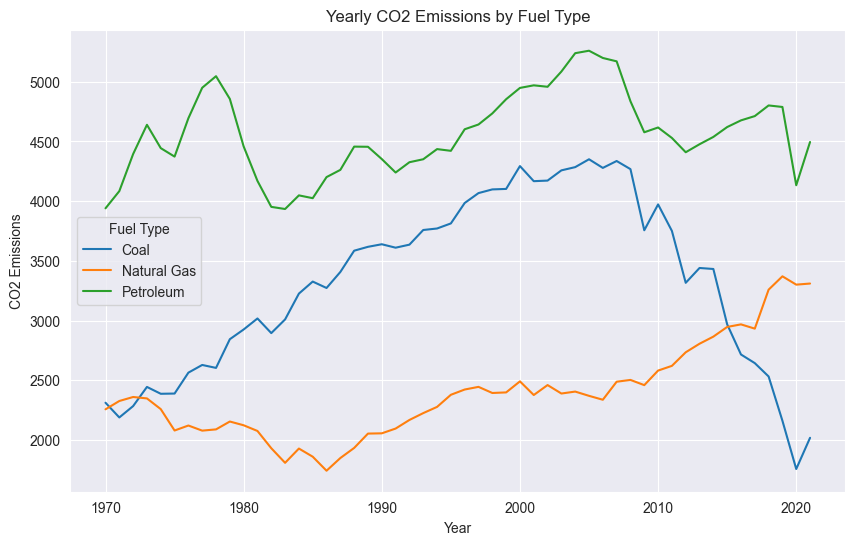

In [1734]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=fuel_group, x='year', y='emission', hue='fuel')
plt.title('Yearly CO2 Emissions by Fuel Type')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend(title='Fuel Type')
plt.grid(True)
plt.show()

In [1735]:
# Group by sector
sector_group = state_excluded.groupby(['year', 'sector'], as_index=False)['emission'].sum()

# Create a dictionary where each key is a type of sector and each value is a DataFrame containing the data for that type of sector
sectors = {sector: sector_group[sector_group['sector'] == sector] for sector in sector_group['sector'].unique()}

# Drop the 'fuel' column from each DataFrame in the dictionary
for sector in sectors:
    sectors[sector] = sectors[sector].drop(columns='sector')
    
sectors['names'] = sector_group['sector'].unique()

sectors

{'Commercial':      year    emission
 0    1970  524.952433
 5    1971  533.704471
 10   1972  543.036232
 15   1973  548.152104
 20   1974  524.472206
 25   1975  495.842203
 30   1976  535.286695
 35   1977  525.717476
 40   1978  529.809257
 45   1979  529.994150
 50   1980  498.762521
 55   1981  464.012750
 60   1982  465.078469
 65   1983  467.359499
 70   1984  487.172277
 75   1985  449.869462
 80   1986  448.596522
 85   1987  454.374918
 90   1988  476.521482
 95   1989  470.481046
 100  1990  454.083712
 105  1991  455.504004
 110  1992  457.831961
 115  1993  453.450935
 120  1994  458.016279
 125  1995  464.534423
 130  1996  482.136891
 135  1997  482.424066
 140  1998  448.603636
 145  1999  452.895111
 150  2000  479.193051
 155  2001  460.682355
 160  2002  463.416120
 165  2003  484.575658
 170  2004  477.436230
 175  2005  455.588962
 180  2006  416.387858
 185  2007  434.887709
 190  2008  452.828748
 195  2009  448.055358
 200  2010  443.079027
 205  2011  445.0064

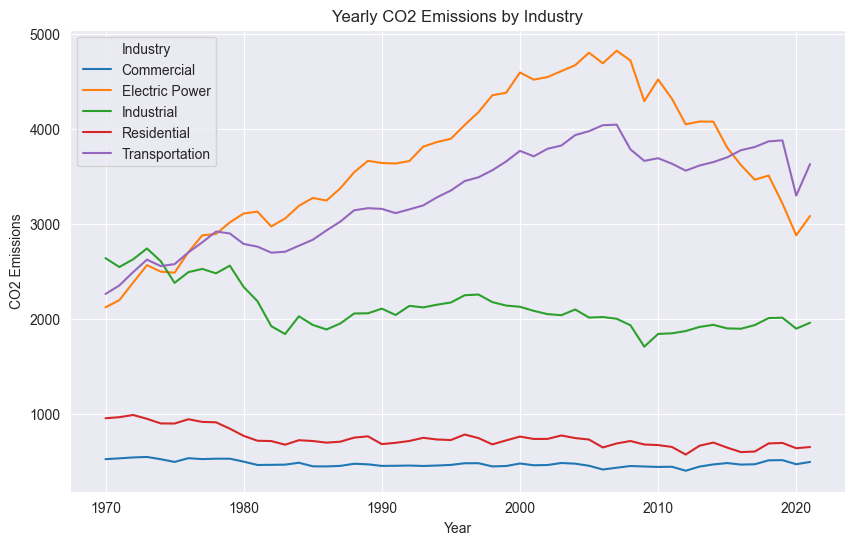

In [1736]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=sector_group, x='year', y='emission', hue='sector')
plt.title('Yearly CO2 Emissions by Industry')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend(title='Industry')
plt.grid(True)
plt.show()

### 2.4 "emission" Data Scaling

In [1737]:
scaler = MinMaxScaler()
fuels["Coal"].loc[:, 'emission'] = scaler.fit_transform(fuels["Coal"]['emission'].values.reshape(-1, 1))
fuels["Natural Gas"].loc[:, 'emission'] = scaler.fit_transform(fuels["Natural Gas"]['emission'].values.reshape(-1, 1))
fuels["Petroleum"].loc[:, 'emission'] = scaler.fit_transform(fuels["Petroleum"]['emission'].values.reshape(-1, 1))

fuels

{'Coal':      year  emission
 0    1970  0.213981
 3    1971  0.166434
 6    1972  0.203142
 9    1973  0.264988
 12   1974  0.242875
 15   1975  0.243615
 18   1976  0.311118
 21   1977  0.335924
 24   1978  0.326408
 27   1979  0.419058
 30   1980  0.450479
 33   1981  0.485994
 36   1982  0.438771
 39   1983  0.482956
 42   1984  0.566316
 45   1985  0.605136
 48   1986  0.584426
 51   1987  0.636223
 54   1988  0.704841
 57   1989  0.717347
 60   1990  0.725632
 63   1991  0.714529
 66   1992  0.724337
 69   1993  0.771651
 72   1994  0.776492
 75   1995  0.792854
 78   1996  0.858833
 81   1997  0.890795
 84   1998  0.902692
 87   1999  0.904257
 90   2000  0.978052
 93   2001  0.929266
 96   2002  0.931160
 99   2003  0.964174
 102  2004  0.974634
 105  2005  1.000000
 108  2006  0.972130
 111  2007  0.994380
 114  2008  0.968136
 117  2009  0.770786
 120  2010  0.854280
 123  2011  0.768617
 126  2012  0.601122
 129  2013  0.649025
 132  2014  0.645776
 135  2015  0.467137
 138 

In [1738]:
sectors["Commercial"].loc[:, 'emission'] = scaler.fit_transform(sectors["Commercial"]['emission'].values.reshape(-1, 1))
sectors["Electric Power"].loc[:, 'emission'] = scaler.fit_transform(sectors["Electric Power"]['emission'].values.reshape(-1, 1))
sectors["Industrial"].loc[:, 'emission'] = scaler.fit_transform(sectors["Industrial"]['emission'].values.reshape(-1, 1))
sectors["Residential"].loc[:, 'emission'] = scaler.fit_transform(sectors["Residential"]['emission'].values.reshape(-1, 1))
sectors["Transportation"].loc[:, 'emission'] = scaler.fit_transform(sectors["Transportation"]['emission'].values.reshape(-1, 1))

sectors

{'Commercial':      year  emission
 0    1970  0.839775
 5    1971  0.900220
 10   1972  0.964668
 15   1973  1.000000
 20   1974  0.836458
 25   1975  0.638729
 30   1976  0.911147
 35   1977  0.845059
 40   1978  0.873318
 45   1979  0.874595
 50   1980  0.658898
 55   1981  0.418904
 60   1982  0.426264
 65   1983  0.442018
 70   1984  0.578852
 75   1985  0.321226
 80   1986  0.312434
 85   1987  0.352342
 90   1988  0.505294
 95   1989  0.463576
 100  1990  0.350331
 105  1991  0.360140
 110  1992  0.376217
 115  1993  0.345961
 120  1994  0.377490
 125  1995  0.422507
 130  1996  0.544076
 135  1997  0.546059
 140  1998  0.312483
 145  1999  0.342122
 150  2000  0.523745
 155  2001  0.395903
 160  2002  0.414784
 165  2003  0.560919
 170  2004  0.511611
 175  2005  0.360727
 180  2006  0.089990
 185  2007  0.217756
 190  2008  0.341664
 195  2009  0.308697
 200  2010  0.274329
 205  2011  0.287640
 210  2012  0.000000
 215  2013  0.300744
 220  2014  0.457586
 225  2015  0.555751

### 2.5 Train & Test Dataset Split

In [1739]:
fuels_train = {
    "Coal": fuels["Coal"][fuels["Coal"]["year"] <= 2015],
    "Natural Gas": fuels["Natural Gas"][fuels["Natural Gas"]["year"] <= 2015],
    "Petroleum": fuels["Petroleum"][fuels["Petroleum"]["year"] <= 2015]
}

fuels_train

{'Coal':      year  emission
 0    1970  0.213981
 3    1971  0.166434
 6    1972  0.203142
 9    1973  0.264988
 12   1974  0.242875
 15   1975  0.243615
 18   1976  0.311118
 21   1977  0.335924
 24   1978  0.326408
 27   1979  0.419058
 30   1980  0.450479
 33   1981  0.485994
 36   1982  0.438771
 39   1983  0.482956
 42   1984  0.566316
 45   1985  0.605136
 48   1986  0.584426
 51   1987  0.636223
 54   1988  0.704841
 57   1989  0.717347
 60   1990  0.725632
 63   1991  0.714529
 66   1992  0.724337
 69   1993  0.771651
 72   1994  0.776492
 75   1995  0.792854
 78   1996  0.858833
 81   1997  0.890795
 84   1998  0.902692
 87   1999  0.904257
 90   2000  0.978052
 93   2001  0.929266
 96   2002  0.931160
 99   2003  0.964174
 102  2004  0.974634
 105  2005  1.000000
 108  2006  0.972130
 111  2007  0.994380
 114  2008  0.968136
 117  2009  0.770786
 120  2010  0.854280
 123  2011  0.768617
 126  2012  0.601122
 129  2013  0.649025
 132  2014  0.645776
 135  2015  0.467137,
 'Na

In [1740]:
fuels_test = {
    "Coal": fuels["Coal"][fuels["Coal"]["year"] > 2015],
    "Natural Gas": fuels["Natural Gas"][fuels["Natural Gas"]["year"] > 2015],
    "Petroleum": fuels["Petroleum"][fuels["Petroleum"]["year"] > 2015]
}

fuels_test

{'Coal':      year  emission
 138  2016  0.369726
 141  2017  0.341867
 144  2018  0.298769
 147  2019  0.155826
 150  2020  0.000000
 153  2021  0.100719,
 'Natural Gas':      year  emission
 139  2016  0.752773
 142  2017  0.730831
 145  2018  0.931249
 148  2019  1.000000
 151  2020  0.957154
 154  2021  0.962839,
 'Petroleum':      year  emission
 140  2016  0.559961
 143  2017  0.586965
 146  2018  0.654265
 149  2019  0.644641
 152  2020  0.150044
 155  2021  0.423330}

In [1741]:
sectors['names']

array(['Commercial', 'Electric Power', 'Industrial', 'Residential',
       'Transportation'], dtype=object)

In [1742]:
sectors_test = {
    "Commercial": sectors["Commercial"][sectors["Commercial"]["year"] > 2015],
    "Electric Power": sectors["Electric Power"][sectors["Electric Power"]["year"] > 2015],
    "Industrial": sectors["Industrial"][sectors["Industrial"]["year"] > 2015],
    "Residential": sectors["Residential"][sectors["Residential"]["year"] > 2015],
    "Transportation": sectors["Transportation"][sectors["Transportation"]["year"] > 2015]
}

sectors_test

{'Commercial':      year  emission
 230  2016  0.445897
 235  2017  0.469809
 240  2018  0.755826
 245  2019  0.769176
 250  2020  0.471219
 255  2021  0.638525,
 'Electric Power':      year  emission
 231  2016  0.554250
 236  2017  0.497285
 241  2018  0.513564
 246  2019  0.404993
 251  2020  0.280758
 256  2021  0.356029,
 'Industrial':      year  emission
 232  2016  0.182292
 237  2017  0.219547
 242  2018  0.291121
 247  2019  0.294656
 252  2020  0.183181
 257  2021  0.243433,
 'Residential':      year  emission
 233  2016  0.061413
 238  2017  0.076218
 243  2018  0.280594
 248  2019  0.293346
 253  2020  0.159889
 258  2021  0.189432,
 'Transportation':      year  emission
 234  2016  0.849282
 239  2017  0.868067
 244  2018  0.901425
 249  2019  0.907321
 254  2020  0.581278
 259  2021  0.767133}

## Step 3: LSTM Dataset Preparation

In [1743]:
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


lookback = 3  # Adjust this based on your data and model performance

In [1744]:
fuel_X_train_dataset = {}
fuel_y_train_dataset = {}

for name in fuels["names"]:
    fuel_X_train_dataset[name], fuel_y_train_dataset[name] = create_dataset(fuels_train[name][['emission']].values, lookback)
    
fuel_X_train_dataset

{'Coal': array([[0.21398083, 0.1664342 , 0.20314206],
        [0.1664342 , 0.20314206, 0.26498843],
        [0.20314206, 0.26498843, 0.24287469],
        [0.26498843, 0.24287469, 0.2436152 ],
        [0.24287469, 0.2436152 , 0.31111783],
        [0.2436152 , 0.31111783, 0.33592357],
        [0.31111783, 0.33592357, 0.32640812],
        [0.33592357, 0.32640812, 0.41905847],
        [0.32640812, 0.41905847, 0.45047926],
        [0.41905847, 0.45047926, 0.48599404],
        [0.45047926, 0.48599404, 0.43877099],
        [0.48599404, 0.43877099, 0.48295567],
        [0.43877099, 0.48295567, 0.56631566],
        [0.48295567, 0.56631566, 0.60513604],
        [0.56631566, 0.60513604, 0.5844262 ],
        [0.60513604, 0.5844262 , 0.63622251],
        [0.5844262 , 0.63622251, 0.70484139],
        [0.63622251, 0.70484139, 0.71734716],
        [0.70484139, 0.71734716, 0.72563191],
        [0.71734716, 0.72563191, 0.71452898],
        [0.72563191, 0.71452898, 0.72433713],
        [0.71452898, 0.724

In [1745]:
fuel_y_train_dataset

{'Coal': array([0.26498843, 0.24287469, 0.2436152 , 0.31111783, 0.33592357,
        0.32640812, 0.41905847, 0.45047926, 0.48599404, 0.43877099,
        0.48295567, 0.56631566, 0.60513604, 0.5844262 , 0.63622251,
        0.70484139, 0.71734716, 0.72563191, 0.71452898, 0.72433713,
        0.77165095, 0.7764919 , 0.79285419, 0.8588334 , 0.8907952 ,
        0.90269191, 0.90425659, 0.97805243, 0.92926582, 0.93116023,
        0.96417445, 0.97463387, 1.        , 0.97212976, 0.99437997,
        0.96813552, 0.77078611, 0.85428039, 0.76861745, 0.60112228,
        0.64902478, 0.64577565, 0.46713714]),
 'Natural Gas': array([0.3719116 , 0.31677465, 0.20683802, 0.23248374, 0.20620882,
        0.21263885, 0.25305889, 0.23378847, 0.20450122, 0.11574733,
        0.04063526, 0.11402449, 0.07212363, 0.        , 0.06533853,
        0.11720047, 0.19104243, 0.19236121, 0.21687273, 0.26111428,
        0.29634135, 0.32827455, 0.39058388, 0.41766987, 0.43134077,
        0.3998888 , 0.40283401, 0.45959295, 0.3

In [1746]:
fuel_X_test_dataset = {}
fuel_y_test_dataset = {}

for name in fuels["names"]:
    fuel_X_test_dataset[name], fuel_y_test_dataset[name] = create_dataset(fuels_test[name][['emission']].values, lookback)
    
fuel_X_test_dataset

{'Coal': array([[0.3697257 , 0.34186716, 0.29876864],
        [0.34186716, 0.29876864, 0.15582592],
        [0.29876864, 0.15582592, 0.        ]]),
 'Natural Gas': array([[0.75277336, 0.73083071, 0.93124917],
        [0.73083071, 0.93124917, 1.        ],
        [0.93124917, 1.        , 0.95715396]]),
 'Petroleum': array([[0.55996095, 0.58696492, 0.65426467],
        [0.58696492, 0.65426467, 0.64464142],
        [0.65426467, 0.64464142, 0.1500442 ]])}

In [1747]:
fuel_y_test_dataset

{'Coal': array([0.15582592, 0.        , 0.1007194 ]),
 'Natural Gas': array([1.        , 0.95715396, 0.96283945]),
 'Petroleum': array([0.64464142, 0.1500442 , 0.42333046])}

## Step 4: LSTM Model

### 4.1 Fuel LSTM Model

#### 4.1.1 Create Models

In [1748]:
fuel_models = {
    "Coal": Sequential(),
    "Natural Gas": Sequential(),
    "Petroleum": Sequential()
}

for key in fuel_models:
    print(key)
    fuel_models[key].add(Input(shape=(lookback, 1)))
    fuel_models[key].add(LSTM(units=50, return_sequences=True))
    fuel_models[key].add(Dropout(0.2))
    fuel_models[key].add(LSTM(units=50, return_sequences=True))
    fuel_models[key].add(Dropout(0.2))
    fuel_models[key].add(LSTM(units=50))
    fuel_models[key].add(Dropout(0.2))
    fuel_models[key].add(Dense(units=1))
    
    fuel_models[key].compile(optimizer='adam', loss='mean_squared_error')
    fuel_models[key].summary()
    


Coal


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_122 (LSTM)                 │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_123 (LSTM)                 │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_124 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Natural Gas


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_125 (LSTM)                 │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_126 (LSTM)                 │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_127 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Petroleum


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_128 (LSTM)                 │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_129 (LSTM)                 │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

#### 4.1.2 Train Models

In [1749]:
# Train the models
for name in fuel_models:
    fuel_models[name].fit(fuel_X_train_dataset[name], fuel_y_train_dataset[name], epochs=50, batch_size=32)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.5047
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4678 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4408 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4037 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3542
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3293 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2702 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2132 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1650 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1134 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0614 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0197
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0402 
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0784 
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━

#### 4.1.3 Test Models

In [1750]:
# Prepare input data for prediction
fuel_X_test_dataset_reshaped = {}
for name in fuel_X_test_dataset:
    fuel_X_test_dataset_reshaped[name] = np.reshape(fuel_X_test_dataset[name], (fuel_X_test_dataset[name].shape[0], fuel_X_test_dataset[name].shape[1], 1))

# Predict the test data
fuel_predictions = {}
for name in fuel_models:
    fuel_predictions[name] = fuel_models[name].predict(fuel_X_test_dataset_reshaped[name])
    fuel_predictions[name] = scaler.inverse_transform(fuel_predictions[name]).flatten()

fuel_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


{'Coal': array([3120.2073, 3072.4148, 2984.1658], dtype=float32),
 'Natural Gas': array([3955.5632, 4135.714 , 4568.071 ], dtype=float32),
 'Petroleum': array([3219.8208, 3257.9224, 3224.8237], dtype=float32)}

In [1751]:
# Calculate the RMSE for each fuel type
from sklearn.metrics import mean_squared_error

fuel_rmse = {}
for name in fuel_predictions:
    fuel_rmse[name] = np.sqrt(mean_squared_error(fuels_test[name].iloc[lookback:, 0], fuel_predictions[name]))
    
fuel_rmse

{'Coal': 1040.5003071123665,
 'Natural Gas': 2214.655126287175,
 'Petroleum': 1214.3055556078757}

In [1752]:
# Calculate the MAE for each fuel type
from sklearn.metrics import mean_absolute_error

fuel_mae = {}
for name in fuel_predictions:
    fuel_mae[name] = mean_absolute_error(fuels_test[name].iloc[lookback:, 0], fuel_predictions[name])

fuel_mae


{'Coal': 1038.9292805989583,
 'Natural Gas': 2199.7826334635415,
 'Petroleum': 1214.18896484375}

In [1753]:
# Combine the predictions into actual fuels & year
fuel_predictions_combined = pd.DataFrame()
for name in fuel_predictions:
    fuel_predictions_combined = pd.concat([fuel_predictions_combined, pd.DataFrame(fuel_predictions[name], columns=[name])], axis=1)

fuel_predictions_combined['year'] = fuels_test['Coal'].iloc[lookback:, 1].values
fuel_predictions_combined = fuel_predictions_combined.set_index('year')

fuel_predictions_combined

,Coal,Natural Gas,Petroleum
year,,,
0.155826,3120.207275,3955.563232,3219.820801
0.000000,3072.414795,4135.713867,3257.922363
0.100719,2984.165771,4568.070801,3224.823730


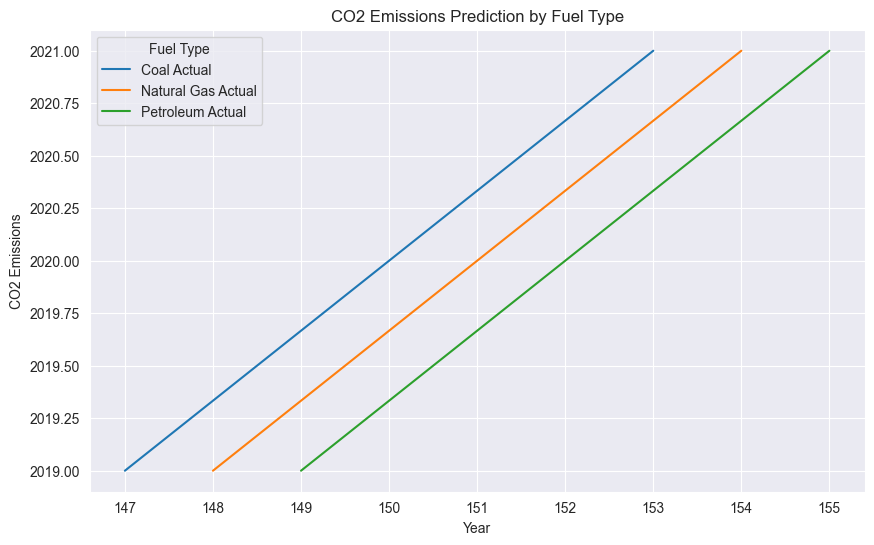

In [1755]:
# Plot the predictions along with the actual data for all fuels & years
plt.figure(figsize=(10, 6))
for name in fuel_predictions:
    plt.plot(fuels_test[name].iloc[lookback:, 0], label=f'{name} Actual')
    # plt.plot(fuel_predictions[name], label=f'{name} Predicted')
plt.title('CO2 Emissions Prediction by Fuel Type')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend(title='Fuel Type')
plt.grid(True)
plt.show()


### 4.2 Sector LSTM Model